In [ ]:
# Data preperation
data <- read.csv("/content/tritium.csv")
x <- as.vector(t(data["pressure"]))
y <- as.vector(t(data["tritium"]))
n <- length(x)
head(x)
head(y)



[1] 1.14702526 0.52936569 0.28822338 0.04935467 1.09945239 1.04581854

[1] 0.59 4.81 4.43 4.30 0.51 0.81

# Nadaraya-Watson

[1] 0.1757296
List of 2
 $ x: num [1:802] 0.00806 0.0153 0.02255 0.02979 0.03704 ...
 $ y: num [1:802] 5.04 5.04 5.05 5.05 5.05 ...


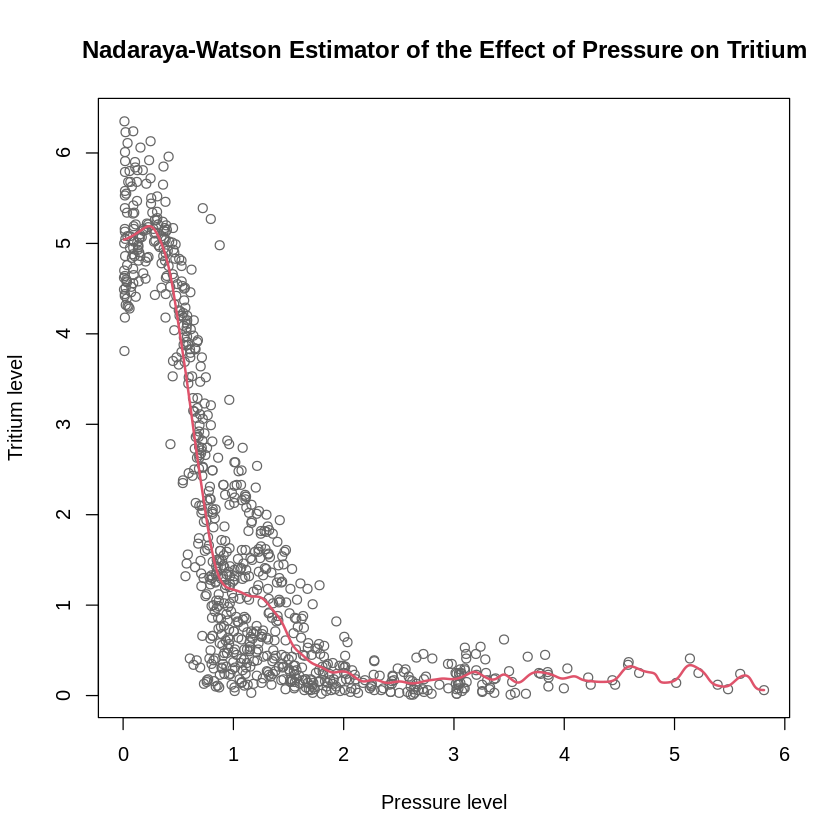

In [ ]:
#Regress the variable tritium on pressure using the Nadaraya-Watson estimator and choose the
#bandwidth parameter h via cross-validation

#cross validation for optimal bandwidth of Nadayara-Whatson in a function. It uses the leave-one-out NW estimator.
NW_CV <- function(x,y,h){
mcv <- rep(0,n)
for(i in 1:n){
mcv[i] <- ksmooth(x[-i], y[-i], kernel="normal",
bandwidth=h, x.points=x[i])$y
}
cv <- mean((y-mcv)^2)
return(cv)
}

#Below, the cross-validation is optimized over h
min_h <- optim(par = 0.3, fn=function(h) NW_CV(x,y,h), method = "BFGS")
#This gives us the optimal bandwidth for the NW estimator on our data
h_cv <- min_h$par
print(h_cv)

#prepare linear space
x_val <- seq(from=min(x), to=max(x), length.out = n)
#NW regression
NWe <- ksmooth(x, y, kernel="normal", bandwidth= h_cv, x.points=x_val)

str(NWe)
#plot of regression over scatter
plot(x, y, col = "gray40", xlab = 'Pressure level', ylab = 'Tritium level', main = "Nadaraya-Watson Estimator of the Effect of Pressure on Tritium")
points(NWe$x, NWe$y, type = 'l', col =2, lwd=2)

[1] 802
[1] 802


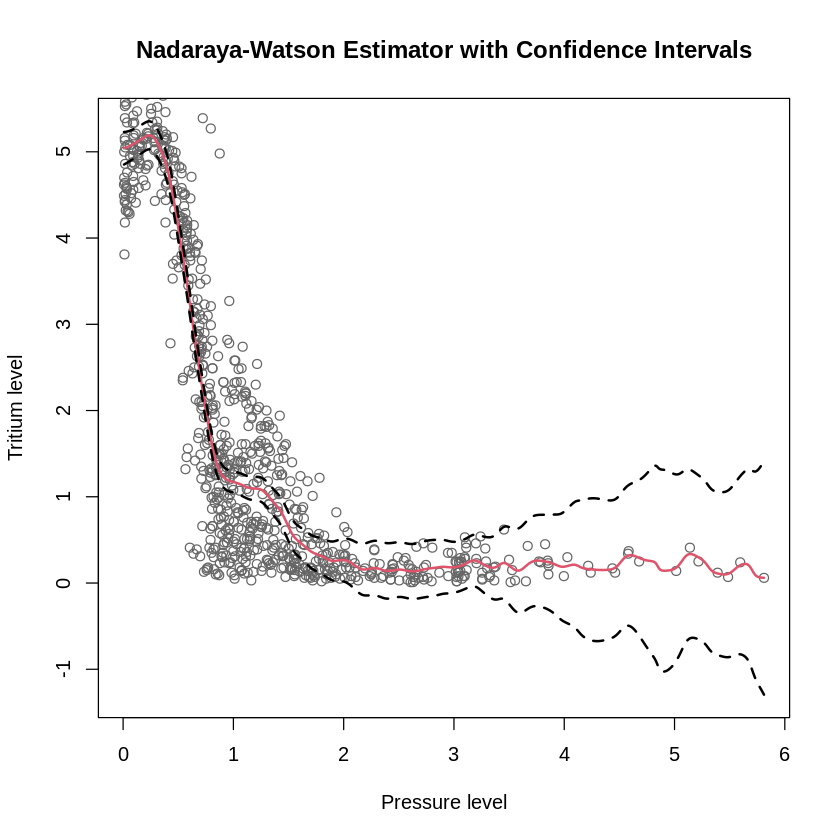

In [ ]:
#Derive 95% pointwise confidence intervals based on the Nadaraya-Watson estimates.

#use Gaussian kernel at each x
NWe1 <- ksmooth(x, y, kernel="normal", bandwidth=h_cv, x.points=x)
#use sample variance for unknown variance
s2 <- mean((y[order(x)]-NWe1$y)^2)
#obtain K2
K2 <- 2*qnorm(0.75)/sqrt(pi)
#use kernel density for the pdf of x
fx = density(x, from=min(x), to=max(x), n=n)
#obtain centre of the interval
NWe2 <- ksmooth(x, y, kernel="normal", bandwidth=h_cv, x.points = fx$x)
#derive bounds using all the tools we got so far
CI_up <- NWe2$y + qnorm(0.975)*sqrt(s2*K2)/sqrt(n*h_cv*fx$y)
CI_lo <- NWe2$y - qnorm(0.975)*sqrt(s2*K2)/sqrt(n*h_cv*fx$y)
print(length(CI_up))
print(length(NWe$x))

#plot of pointwise CI's and regression over scatter
plot(x, y, col = "gray40", ylim = c(min(CI_lo), max(CI_up)), xlab = 'Pressure level', ylab = 'Tritium level', main = "Nadaraya-Watson Estimator with Confidence Intervals")
points(NWe$x, NWe$y, type = 'l', col =2, lwd=2)
points(NWe$x, CI_up, type="l", lty=2, lwd=2)
points(NWe$x, CI_lo, type="l", lty=2, lwd=2)

# Heteroskedasticity

[1] 802
[1] 802


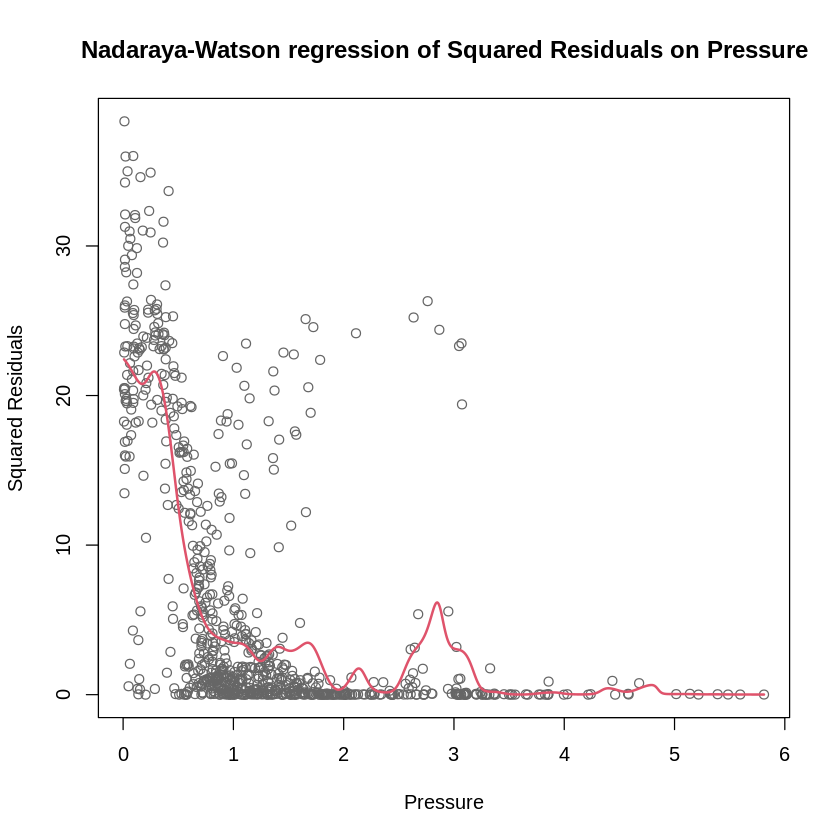

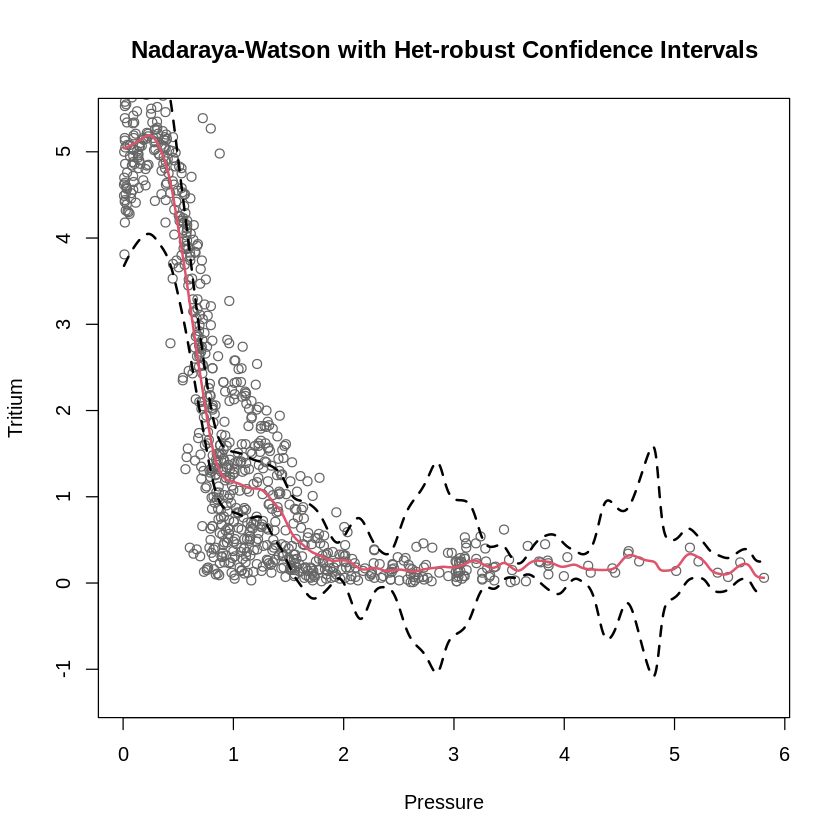

In [ ]:
#perform NW on squared residuals

#square residuals
e <- NWe$y - y
e2 <- e^2
#get optimal bandwidth for NW on squared residuals
min_h_2 <- optim(par = 0.3, fn=function(h) NW_CV(x,e2,h), method = "BFGS")
h_cv_2 <- min_h_2$par

#NW regression
NWe_2 <- ksmooth(x, e2, kernel="normal", bandwidth= h_cv_2, x.points=x_val)
#plot regression over scatter of squared residuals
plot(x, e2, col = "gray40", xlab = 'Pressure', ylab = 'Squared Residuals', main = 'Nadaraya-Watson regression of Squared Residuals on Pressure')
points(NWe_2$x, NWe_2$y, type = 'l', col =2, lwd=2)

#derive new pointwise CI's now that we found heteroskedasticity.
#Look at report for reason of using the NW regression on squared residuals (obtained just above here) for the unknown conditional variance.
#same recipe as before, just different sigma_i2
NWe1 <- ksmooth(x, y, kernel="normal", bandwidth=h_cv, x.points=x)
sigma_i2 <- NWe_2$y
K2 <- 2*qnorm(0.75)/sqrt(pi)
fx = density(x, from=min(x), to=max(x), n=n)
NWe2 <- ksmooth(x, y, kernel="normal", bandwidth=h_cv, x.points = fx$x)
CI_up1 <- NWe2$y + qnorm(0.975)*sqrt(sigma_i2*K2)/sqrt(n*h_cv*fx$y)
CI_lo1 <- NWe2$y - qnorm(0.975)*sqrt(sigma_i2*K2)/sqrt(n*h_cv*fx$y)
print(length(CI_up))
print(length(NWe$x))

#plot of new and improved pointwise CI's and the regression over scatter
plot(x, y, col = "gray40", ylim = c(min(CI_lo1), max(CI_up1)), xlab = 'Pressure', ylab = 'Tritium', main = 'Nadaraya-Watson with Het-robust Confidence Intervals')
points(NWe$x, NWe$y, type = 'l', col =2, lwd=2)
points(NWe$x, CI_up1, type="l", lty=2, lwd=2)
points(NWe$x, CI_lo1, type="l", lty=2, lwd=2)

# local quadratic regression

[1] 0.4249411


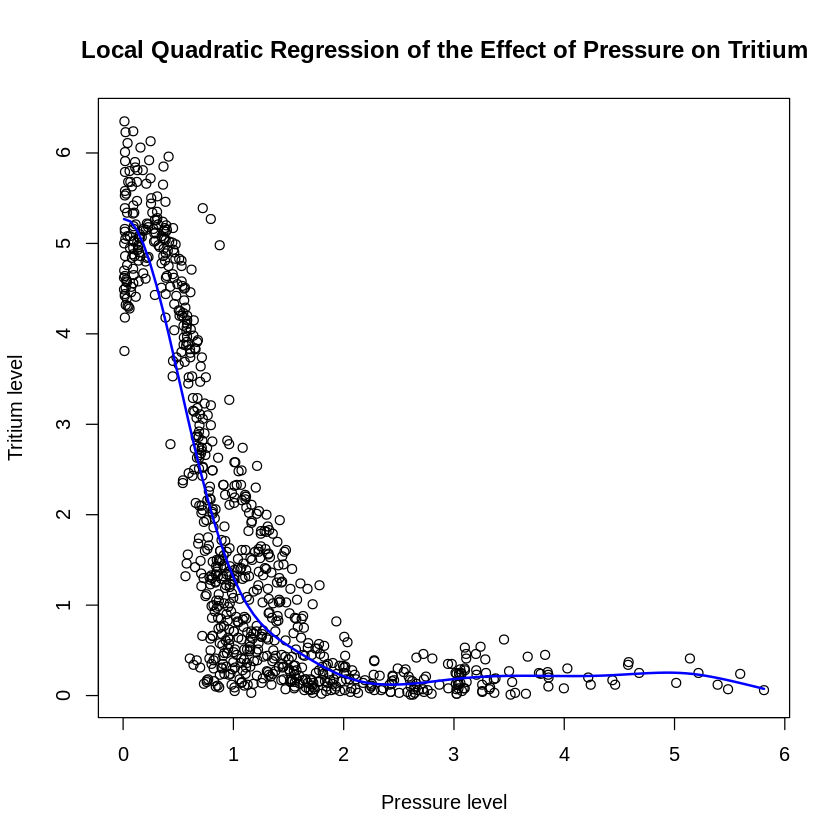

In [ ]:
#Regress the variable tritium on pressure using a local quadratic regression (p = 2).

#prepare linear space
xval <- seq(from=min(x), to=max(x), length.out = n)

#cross validation for optimal bandwidth of Local Quadratic Polynomial regression in a function. It uses the leave-one-out LQR estimator.
LQP_CV <- function(x,y,h){
mcv <- rep(0,n)
for(i in 1:length(x)){
  z1 <- x-xval[i]
  z2 <- z1^2
  w <- dnorm((xval[i]-x)/h)
  wls <- lm(y[-i]~z1[-i] +z2[-i] , weights = w[-i])
  mcv[i] <- wls$coef[1]
  }
cv <- mean((y-mcv)^2)
return(cv)
}
#optimize to get optimal bandwidth
min_h_LQP <- optim(par = 0.3, fn=function(h) LQP_CV(x,y,h), method = "BFGS")

h_cv_LQP <- min_h_LQP$par
print(h_cv_LQP)

xval <- seq(min(x),max(x),length.out = 100)

#prepare vectors to store estimate, and additionally first/second derivative estimates
llest <- rep(NA, length(xval))
llest1 <- rep(NA, length(xval))
llest2 <- rep(NA, length(xval))

#perform WLS for each xi on regression (y ~ x + x^2)
h <- h_cv_LQP
for(i in 1:length(xval)){
  #prepare x and x^2
  z1 <- x-xval[i]
  z2 <- z1^2
  #get weights with Gaussian kernel
  w <- dnorm((xval[i]-x)/h)
  #do wls
  wls <- lm(y~z1 +z2 , weights = w)
  #store estimates obtained at x=xi
  llest[i] <- wls$coef[1]
  llest1[i] <- wls$coef[2]
  llest2[i] <- wls$coef[3]/2
  }

#plot of the regression over scatter
plot(x,y, xlab = 'Pressure level', ylab = 'Tritium level', main = "Local Quadratic Regression of the Effect of Pressure on Tritium")
points(xval,llest,type = "l",col='blue',lwd=2)


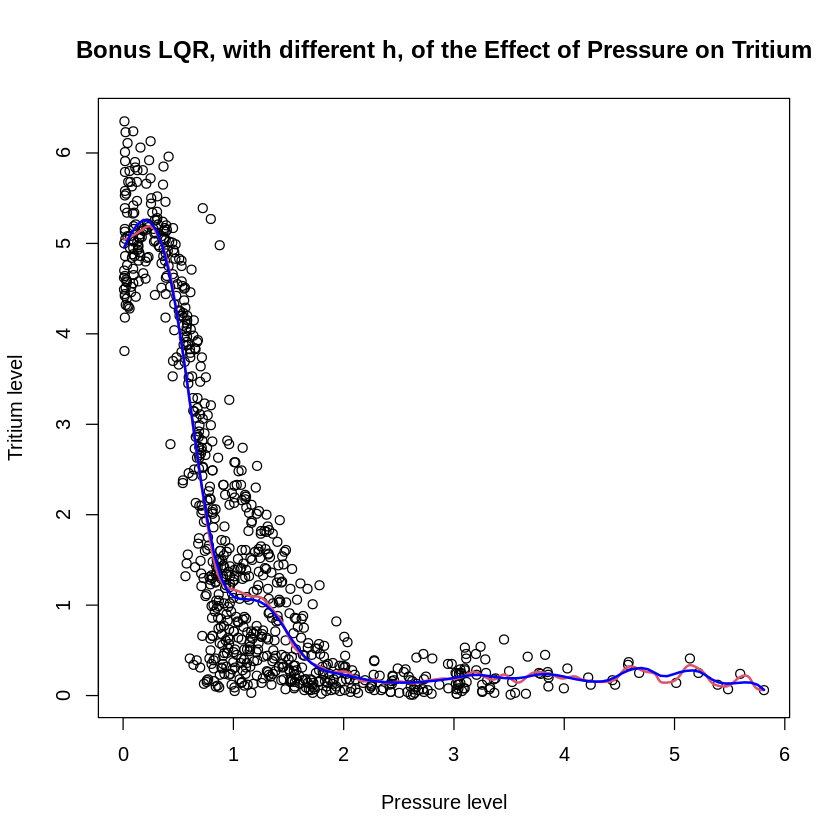

In [ ]:
#we did a bonus LQR to use similar h as in NW for comparison in the report.
#This is not the assignment but something we thought to check out. so you might want to ignore this :)
xval <- seq(min(x),max(x),length.out = 100)
Bllest <- rep(NA, length(xval))

h <- h_cv
for(i in 1:length(xval)){
  z1 <- x-xval[i]
  z2 <- z1^2
  w <- dnorm((xval[i]-x)/h)
  wls <- lm(y~z1 +z2 , weights = w)
  Bllest[i] <- wls$coef[1]
  }
plot(x,y, xlab = 'Pressure level', ylab = 'Tritium level', main = "Bonus LQR, with different h, of the Effect of Pressure on Tritium")
points(NWe$x, NWe$y, type = 'l', col =2, lwd=2)
points(xval, Bllest,type = "l",col='blue',lwd=2)


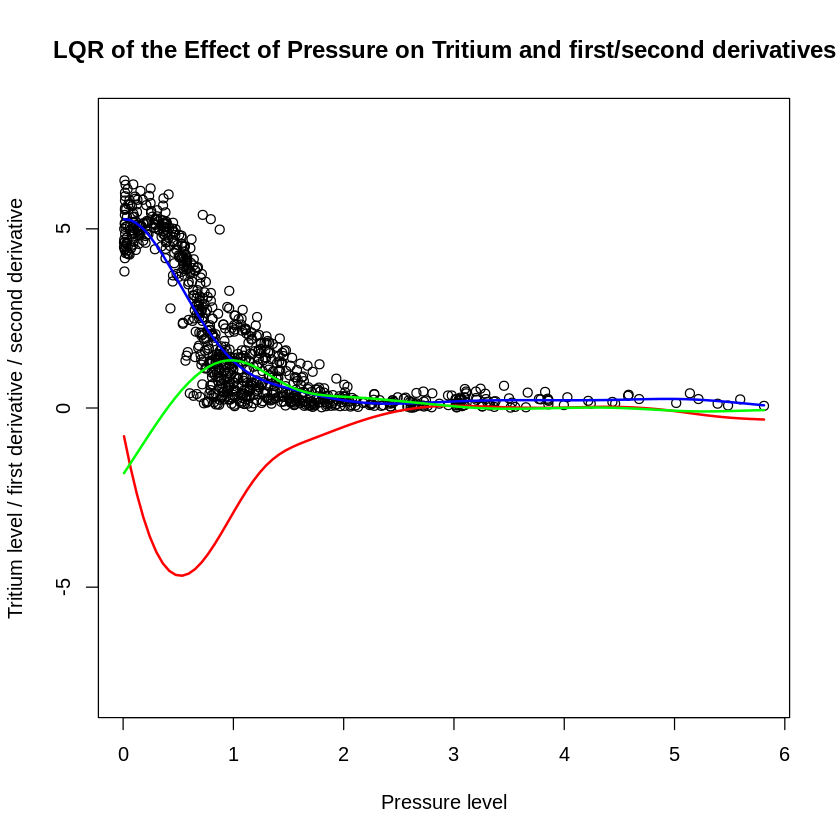

In [ ]:
#same plot as before this bonus (a small tangent really..), but now including estimates for first and second derivatives
plot(x,y, xlab = 'Pressure level', ylab = 'Tritium level / first derivative / second derivative', main =  "LQR of the Effect of Pressure on Tritium and first/second derivatives", ylim=c(-8,8))
points(xval,llest,type = "l",col='blue',lwd=2)
points(xval,llest1,type = "l",col='red',lwd=2)
points(xval,llest2,type = "l",col='green',lwd=2)